In [19]:
import os
import osmnx as ox
import networkx as nx
import folium
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

%matplotlib inline

# Output directory for Week 2
output_dir = "week2"
os.makedirs(output_dir, exist_ok=True)

print("Week 2 environment ready ✔")


Week 2 environment ready ✔


In [20]:
geolocator = Nominatim(user_agent="AI_Green_Transportation_APP")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

origin_input = input("Enter Origin location (Bengaluru): ")
dest_input = input("Enter Destination location (Bengaluru): ")

origin = geocode(origin_input + ", Bengaluru, India", timeout=10)
destination = geocode(dest_input + ", Bengaluru, India", timeout=10)

if origin is None or destination is None:
    raise ValueError("Invalid location. Try a different place name.")

origin_lat, origin_lon = origin.latitude, origin.longitude
dest_lat, dest_lon = destination.latitude, destination.longitude

origin_name = origin.address
dest_name = destination.address

print("Origin:", origin_name)
print("Destination:", dest_name)


Enter Origin location (Bengaluru):  Kempegowda International Airport Bengaluru
Enter Destination location (Bengaluru):  Electronic City Bengaluru


Origin: Kempegowda International Airport, Airport City Road, Bengaluru, Devanahalli taluku, Bengaluru Rural, Karnataka, 560300, India
Destination: State Bank of India, Hosur Road, Bengaluru South City Corporation, Bengaluru, Bangalore South, Bengaluru Urban, Karnataka, 560500, India


In [21]:
print("Downloading map graph…")
G = ox.graph_from_place("Bengaluru, India", network_type="drive")
print("Map graph ready ✔")


Map graph ready ✔


In [22]:
origin_node = ox.nearest_nodes(G, origin_lon, origin_lat)
destination_node = ox.nearest_nodes(G, dest_lon, dest_lat)

shortest_route = nx.shortest_path(G, origin_node, destination_node, weight='length')
shortest_length_m = nx.shortest_path_length(G, origin_node, destination_node, weight='length')
shortest_length_km = shortest_length_m / 1000

print("Shortest Distance:", round(shortest_length_km, 2), "km ✔")


Shortest Distance: 32.89 km ✔


In [23]:
def get_emission_factor(hw):
    if hw in ["motorway"]:
        return 90
    elif hw in ["trunk"]:
        return 100
    elif hw in ["primary"]:
        return 120
    elif hw in ["secondary"]:
        return 150
    else:
        return 180  # congested small roads

for u, v, d in G.edges(data=True):
    hw = d.get("highway", "")
    if isinstance(hw, list):
        hw = hw[0]

    ef = get_emission_factor(hw)
    d["emission_factor"] = ef
    d["emission_weight"] = d["length"] * ef  # main cost function

# Compute low-emission route
low_route = nx.shortest_path(G, origin_node, destination_node, weight='emission_weight')

low_length_m = sum(G[u][v][0].get("length", 0) for u, v in zip(low_route[:-1], low_route[1:]))
low_length_km = low_length_m / 1000

print("Low-Emission Distance:", round(low_length_km, 2), "km")


Low-Emission Distance: 33.89 km


In [24]:
def calculate_emission(route):
    total = 0
    for u, v in zip(route[:-1], route[1:]):
        edge = G[u][v][0]
        length_km = edge["length"] / 1000
        total += length_km * edge["emission_factor"]
    return total

shortest_emission = calculate_emission(shortest_route)
low_emission = calculate_emission(low_route)

print("\n📌 Correct Emission Calculations:")
print("Shortest Route:", round(shortest_emission, 2), "g CO2")
print("Low-Emission Route:", round(low_emission, 2), "g CO2 🟢")



📌 Correct Emission Calculations:
Shortest Route: 4405.01 g CO2
Low-Emission Route: 4115.74 g CO2 🟢


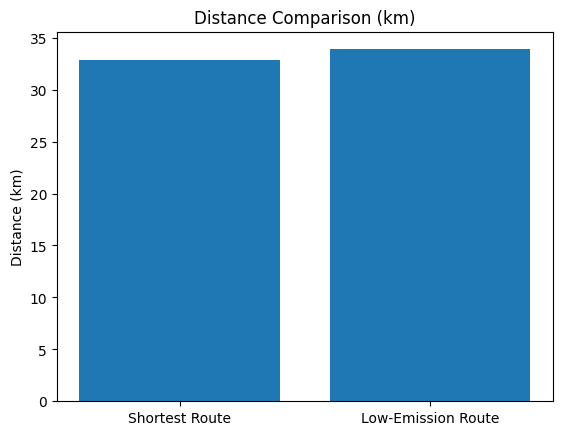

Distance chart saved ✔


In [25]:
labels = ["Shortest Route", "Low-Emission Route"]
distances = [shortest_length_km, low_length_km]

plt.figure()
plt.bar(labels, distances)
plt.title("Distance Comparison (km)")
plt.ylabel("Distance (km)")
plt.savefig(os.path.join(output_dir, "week2_distance_comparison.png"))
plt.show()

print("Distance chart saved ✔")


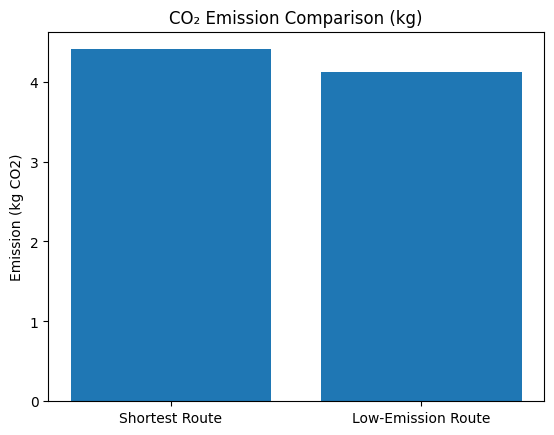

Emission chart saved ✔


In [26]:
emissions = [shortest_emission/1000, low_emission/1000]  # convert g → kg

plt.figure()
plt.bar(labels, emissions)
plt.title("CO₂ Emission Comparison (kg)")
plt.ylabel("Emission (kg CO2)")
plt.savefig(os.path.join(output_dir, "week2_emission_comparison.png"))
plt.show()

print("Emission chart saved ✔")


In [27]:
short_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in shortest_route]
short_map = folium.Map(location=short_coords[0], zoom_start=12)
folium.PolyLine(short_coords, color="blue", weight=5).add_to(short_map)
short_map.save(os.path.join(output_dir, "week2_shortest_route_map.html"))

low_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in low_route]
low_map = folium.Map(location=low_coords[0], zoom_start=12)
folium.PolyLine(low_coords, color="green", weight=5).add_to(low_map)
low_map.save(os.path.join(output_dir, "week2_low_emission_route_map.html"))

print("Both maps saved inside 'week2' folder ✔")


Both maps saved inside 'week2' folder ✔
